## Vamos Começar

Baixar e Instalar o [Anaconda](https://www.continuum.io/downloads) (Python 3.5)

Inicializar o Spyder (IDE Python)

![](../resource/menu-anaconda-spyder.gif)

Painéis Disponíveis:

1. Editor de arquivos
1. Inspetor de Variáveis
1. Console Python

![](../resource/spyder.png)

**Atalhos Importantes:**

+ F5 - Executa Script
+ Ctrl+Espaço - Lista de Funções
+ Ctrl+1 - Comenta Linha
+ Ctrl+I - Mostra Documentação
+ Ctrl+Shift+I - Foco no Console
+ Ctrl+Shift+V - Foco Inspetor de Variáveis
+ Ctrl+Shift+E - Foco no Editor

## Exercício - Análise de Poço por Curvas de Declínio

*Baseado no Exemplo 11.1 do livro [Engenharia de Reservatórios de Petróleo](http://www.saraiva.com.br/engenharia-de-reservatorios-de-petroleo-198191.html) de Rosa, A. et al.*

### Curvas de Declínio

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/GlennPool.jpg/220px-GlennPool.jpg)


>Método simplificado e bastante usado na prática para a realização de ajuste de histórico e/ou previsão do comportamento de poços isolados (Rosa, A. et al, 2006)

Equação do Declinio Hiperbólico:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

Dado o histórico de produção de um poço na tabela abaixo:

| *t (ano)* | *q (m³std/d)* |
|-----------|---------------|
| 0         | 100           |
| 1         | 77.0          |
| 2         | 61.0          |
| 3         | 49.5          |
| 4         | 41.0          |
| 5         | 34.5          |

Determinar, através da equação do declínio hiperbólico:

 1. Tempo de abandono, considerando uma vazão de abandono de 5 m³std/d;
 1. Produção acumulada até o abandono.


### Solução

Vamos criar uma lista com os dados do histórico

In [1]:
qm = [100, 77, 61, 49.5, 41, 34.5]

**Listas não são Arrays!**

|Lista                            |Array               |
|:-------------------------------:|:------------------:|
|![](../resource/paperbox.jpg) |![](../resource/beerbox.jpg)|

In [2]:
import numpy as np

In [3]:
qm = np.array([100, 77, 61, 49.5, 41, 34.5])
tsteps = np.arange(6)

### Funções

Utilizando a equação de Declínio Hiperbólico, a vazão $q$ de um poço no tempo $t$ pode é dada por:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

Podemos escrever esta equação em Python da seguinte forma:

In [4]:
def declinio_hiperb(t, qi, ai, n):
    '''
    Calcula vazão instantânea do poço usando curva de declinio hiperbólica
    '''
    q = qi / (1 + n * ai * t) ** (1 / n)
    return q

Tipagem dinâmica e foco na legibilidade

Exemplo da mesma função em C++:

```C
#include <math.h>

/*
 *  Calcula vazão instantânea do poço usando curva de declinio hiperbólica
 */
const double &declinio_hiper(double &t, double &qi, double &ai, double &n) 
{
    return qi / pow((1 + n * ai * t), (1 / n));
}
```

Vamos testar a função

In [5]:
declinio_hiperb(2, 100, 0.3, 1/3)

57.87037037037038

Como nossos vetores tem suporte a operadores, podemos chamar a função passando um valor escalar ou vetorial:

In [6]:
declinio_hiperb(tsteps, 100, 0.3, 1/3)

array([ 100.        ,   75.13148009,   57.87037037,   45.51661356,
         36.44314869,   29.62962963])

### Plotando

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

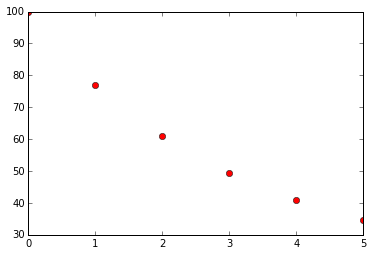

In [8]:
plt.plot(tsteps, qm, "ro")

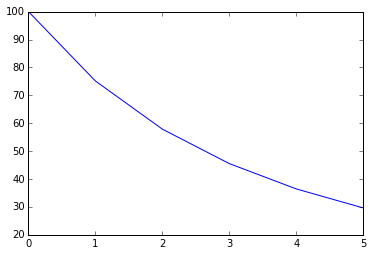

In [9]:
qs = declinio_hiperb(tsteps, 100, 0.3, 1/3)
plt.plot(tsteps, qs)

- [`plot()` function](http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) - documentação da função `plot()`

### Ajustando os Parâmetros da Curva de Declínio

Usaremos a função [curve_fit][curve-fit] da [SciPy][scipy-ref] para encontrar os parâmetros da curva de declínio para nossos dados de histórico:

[scipy-ref]: http://docs.scipy.org/doc/scipy-0.14.0/reference/index.html
[curve-fit]: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.curve_fit.html

In [10]:
import scipy.optimize

params, fitted = scipy.optimize.curve_fit(declinio_hiperb, tsteps, qm, p0=[100, 0.3, 1/3])
qi_fit, ai_fit, n_fit = params

In [11]:
print(qi_fit)
print(ai_fit)
print(n_fit)

100.012075806
0.279526724773
0.489424884092


Plotando contra os dados de histórico, temos:

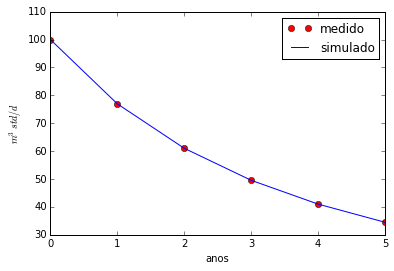

In [12]:
qs = declinio_hiperb(tsteps, qi_fit, ai_fit, n_fit)
plt.plot(tsteps, qm, "ro", label="medido")
plt.plot(tsteps, qs, label="simulado")
plt.xlabel("anos")
plt.ylabel("$m^3 std/d$")
plt.legend()

### Solução do Item 1: Tempo de Abandono

Para encontrar o tempo de abandono, vamos isolar $t$ na equação de declíneo:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

temos:

$$t = \frac{(q_i/q)^n - 1}{n a_i}$$


In [13]:
def tempo_abandono(qa, qi, ai, n):
    t = ((qi/qa)**n - 1) / (ai*n)
    return t

In [14]:
qa = 5
tempo_abandono(qa, qi_fit, ai_fit, n_fit)

24.36224982496239

Temos que o tempo de abandono é de **24.36 anos**

### Solução do Item 2: Produção Acumulada

A produção acumulada até o abandono pode ser calculada integrando-se o a função de declíneo no interavlo de produção $(0, 24.36)$. Para isso vamos usar a função [quad][quad] da [SciPy][scipy-ref].

[scipy-ref]: http://docs.scipy.org/doc/scipy-0.14.0/reference/index.html
[quad]: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

In [15]:
import scipy.integrate

result, error = scipy.integrate.quad(declinio_hiperb, 0, 24.36, (qi_fit, ai_fit, n_fit))
Np = result * 365.25 # mult por 365.25 (vazão está em dias e tempo em anos)
print("Np: %.2f" % (Np))

Np: 200503.96


Produção acumulada até o tempo de abandono de **200.503 m³std**

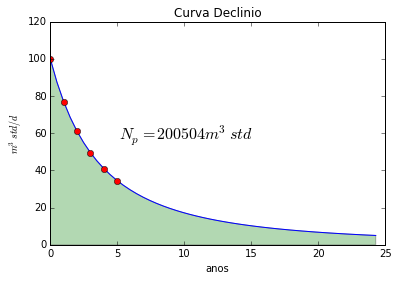

In [16]:
tsteps_a = np.linspace(0, 24.3)
qs_a = declinio_hiperb(tsteps_a, qi_fit, ai_fit, n_fit)

plt.plot(tsteps_a, qs_a)
plt.plot(tsteps, qm, "ro")
plt.xlabel("anos")
plt.ylabel("$m^3 std/d $")
plt.title("Curva Declinio")
plt.annotate(r"$N_p = %.0f m^3std$" % Np, xy=(0.3, 0.5), xycoords='figure fraction', size=16)
plt.fill_between(tsteps_a, qs_a, 0, facecolor="g", alpha=0.3)
plt.savefig("declinio.png", dpi=300)

#### Links
- [Matplotlib Gallery](http://matplotlib.org/gallery.html) - exemplos de gráficos gerados pela Matplotlib acompanhado do código-fonte
- [SciPy - Guia de Referência](http://docs.scipy.org/doc/scipy/reference/)
- [Numpy for Matlab users](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html#general-purpose-equivalents)

### Round Bônus

Executar o *Anaconda Command Prompt* e instalar a biblioteca `yahoo_finance` com o seguinte comando:

```
pip install yahoo_finance
```

In [17]:
import yahoo_finance

yahoo_finance.Currency("USDBRL").get_rate()

'3.7408'

In [18]:
brent_share = yahoo_finance.Share("BZZ15.NYM")
brent_price = float(brent_share.get_price())
"OIL Brent: U$ %.2f" % (brent_price)

'OIL Brent: U$ 47.24'

In [19]:
# Imprimindo valor em moeda corrente, agrupand milhar
m3tobrl = 6.28981077
Np_usd = Np * m3tobrl * brent_price
print("Produção em US$: %.2f" % (Np_usd))

Produção em US$: 59575873.77


In [20]:
import locale

dolar = float(yahoo_finance.Currency("USDBRL").get_rate())
# Aplica as configurações regionais que estão definidas no computador
locale.setlocale(locale.LC_MONETARY, "Portuguese_Brazil")
locale.currency(Np_usd * dolar, grouping=True)

'R$ 222.843.555,82'

- [locale](https://docs.python.org/3.4/library/locale.html)
- [yahoo_finance](https://pypi.python.org/pypi/yahoo-finance/1.2.1)